In [1]:
import keras.callbacks as cb
from keras.datasets import mnist
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD,Adam
from keras.regularizers import l1, l2
from keras.utils import np_utils

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import time
import pandas as pd


Using TensorFlow backend.


# Pre-processing

In [2]:
def PreprocessDataset():
    from sklearn import preprocessing
    data = pd.read_csv('Data/cleaned_data.csv',index_col=False,low_memory=False)
    data = data.reindex(np.random.permutation(data.index))
    cols = data.columns
    x_columns = cols.drop("match_result")
    
    x = data[x_columns]
    y = data['match_result']
    
    train_max_row = int(data.shape[0]*0.9)
    
    x_train = x.iloc[:train_max_row]
    x_test = x.iloc[train_max_row:]
    
    y_train = y.iloc[:train_max_row]
    y_test = y.iloc[train_max_row:]
    
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    ################Pre-processing###########
    min_max_scaler = preprocessing.MinMaxScaler()
    x_train = min_max_scaler.fit_transform(x_train)
    x_test = min_max_scaler.fit_transform(x_test)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = PreprocessDataset()

In [3]:
x_train[3]

array([ 0.02764423,  0.1372549 ,  0.07351763,  0.02092812,  0.10169492,
        0.07314629,  0.03693931,  0.19125683,  0.13389121,  0.02644231,
        0.13144181,  0.07314629,  0.02922338,  0.15519399,  0.07852564,
        0.02058908,  0.10288066,  0.05339806])

In [4]:
'''
data = pd.read_csv('Data/cleaned_data.csv',index_col=False,low_memory=False)
data = data.reindex(np.random.permutation(data.index))
cols = data.columns
x_columns = cols.drop("match_result")
y = data['match_result']
x = data[x_columns]

type(x)
'''
y_train.shape


(19917, 3)

In [5]:
def DefineModel():

    ################################################################
    # Activity 2 (Network Structure):
    # Group A: uses only 1 layer
    # second_layer_width = 0
    #
    # Group B: uses 2 layers of a tower-shaped (same width) network.
    # second_layer_width = 128
    #
    # Group C: uses 2 layers of a pyramid-shaped (shrink width) network.
    # second_layer_width = 64
    ################################################################
    first_layer_width = 128
    second_layer_width = 64   
    
    ################################################################
    # Activity 3 (Activation Function):
    # Group A uses ReLU.
    # activation_func = 'relu' 
    # 
    # Group B uses Sigmoid.
    # activation_func = 'sigmoid'
    #
    # Group C uses Tanh.
    # activation_func = 'tanh'
    ################################################################
    activation_func = 'relu' 

    ################################################################    
    # Activity 4 (Loss Function):
    # Group A uses cross entropy.
    # loss_function = 'categorical_crossentropy'
    # 
    # Group B uses cross entropy.
    # loss_function = 'categorical_crossentropy'
    # 
    # Group C uses squared error.
    # loss_function = 'mean_squared_error'
    ################################################################    
    loss_function = 'categorical_crossentropy'
    #loss_function = 'mean_squared_error'
    
    #################################################################    
    # Activity 5 (Dropout):
    # Group A uses 0% dropout.
    #
    # Group B uses 50% dropout.
    # dropout_rate = 0.5
    #
    # Group C uses 90% dropout.
    # dropout_rate = 0.9
    #################################################################    
    dropout_rate = 0.3
    
    ################################################################    
    # Activity 6 (Regularization):
    # Group A uses L1 regularizer
    # weight_regularizer = l1(0.01)
    #
    # Group B uses L2 regularizer
    #weight_regularizer = l2(0.01)
    # 
    # Group C uses no regularizer
    # weight_regularizer = None
    ################################################################
    weight_regularizer = None

    ################################################################    
    # Activity 8 (Learning Rate):
    # Group A uses learning rate of 0.1.
    # learning_rate = 0.1
    # 
    # Group B uses learning rate of 0.01.
    # learning_rate = 0.01
    #
    # Group C uses learning rate of 0.5.    
    # learning_rate = 0.5
    ################################################################
    learning_rate = 0.001
    
    ## Initialize model.
    model = Sequential()

    ## First hidden layer with 'first_layer_width' neurons. 
    ## Also need to specify input dimension.
    ## 'Dense' means fully-connected.
    model.add(Dense(16, input_dim=18, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(dropout_rate))
    

    
    model.add(Dense(16))
    model.add(Activation(activation_func))   
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(12))
    model.add(Activation(activation_func))   
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(12))
    model.add(Activation(activation_func))   
    model.add(Dropout(dropout_rate))
    
    
    model.add(Dense(8))
    model.add(Activation(activation_func))   
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(6))
    model.add(Activation(activation_func))   
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(4))
    model.add(Activation(activation_func))   
    model.add(Dropout(0.1))

    
    
    ## Last layer has the same dimension as the number of classes
    model.add(Dense(3))
    ## For classification, the activation is softmax
    model.add(Activation('softmax'))
    ## Define optimizer. In this tutorial/codelab, we select SGD.
    ## You can also use other methods, e.g., opt = RMSprop()
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #opt = SGD(lr=learning_rate, clipnorm=5.)
    ## Define loss function = 'categorical_crossentropy' or 'mean_squared_error'
    model.compile(loss=loss_function, optimizer=opt, metrics=["accuracy"])

    return model

In [6]:
def TrainModel(data=None, epochs=20):
    ################################################################
    # Activity 7 (Mini-batch):
    # Group A uses mini-batch of size 128.
    # batch = 128
    #
    # Group B uses mini-batch of size 256.
    # batch = 256
    # 
    # Group C uses mini-batch of size 512.
    # batch = 512
    ################################################################
    batch=128
    start_time = time.time()
    model = DefineModel()
    if data is None:
        print("Must provide data.")
        return
    x_train, x_test, y_train, y_test = data
    print('Start training.')
    ## Use the first 55,000 (out of 60,000) samples to train, last 5,500 samples to validate.
    history = model.fit(x_train[:17500], y_train[:17500], nb_epoch=epochs, batch_size=batch,
              validation_data=(x_train[17500:], y_train[17500:]))
    print("Training took {0} seconds.".format(time.time() - start_time))
    return model, history

In [7]:
trained_model, training_history = TrainModel(data=[x_train, x_test, y_train, y_test],epochs = 30)

Start training.
Train on 17500 samples, validate on 2417 samples
Epoch 1/30
17500/17500 [==============================] - 0s - loss: 1.0826 - acc: 0.4390 - val_loss: 1.0653 - val_acc: 0.4547
Epoch 2/30
17500/17500 [==============================] - 0s - loss: 1.0493 - acc: 0.4563 - val_loss: 1.0139 - val_acc: 0.4547
Epoch 3/30
17500/17500 [==============================] - 0s - loss: 1.0366 - acc: 0.4563 - val_loss: 1.0239 - val_acc: 0.4547
Epoch 4/30
17500/17500 [==============================] - 0s - loss: 1.0298 - acc: 0.4565 - val_loss: 1.0271 - val_acc: 0.4547
Epoch 5/30
17500/17500 [==============================] - 0s - loss: 1.0280 - acc: 0.4565 - val_loss: 1.0165 - val_acc: 0.4547
Epoch 6/30
17500/17500 [==============================] - 0s - loss: 1.0242 - acc: 0.4565 - val_loss: 1.0138 - val_acc: 0.4547
Epoch 7/30
17500/17500 [==============================] - 0s - loss: 1.0241 - acc: 0.4564 - val_loss: 1.0179 - val_acc: 0.4547
Epoch 8/30
17500/17500 [======================

In [8]:
def PlotHistory(train_value, test_value, value_is_loss_or_acc):
    f, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    ## Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc = 0) 
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)  
    


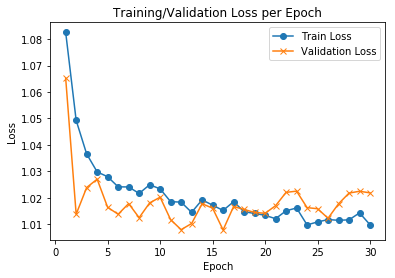

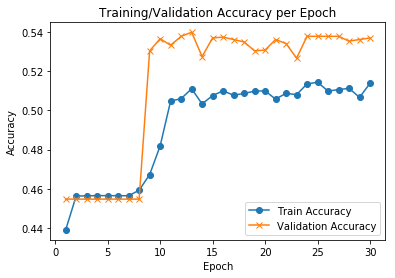

In [9]:
    
PlotHistory(training_history.history['loss'], training_history.history['val_loss'], 'Loss')
PlotHistory(training_history.history['acc'], training_history.history['val_acc'], 'Accuracy')

In [10]:
def drawWeightHistogram(x):
    ## the histogram of the data
    fig = plt.subplots()
    n, bins, patches = plt.hist(x, 50)
    plt.xlim(-0.5, 0.5)
    plt.xlabel('Weight')
    plt.ylabel('Count')
    zero_counts = (x == 0.0).sum()
    plt.title("Weight Histogram. Num of '0's: %d" % zero_counts)

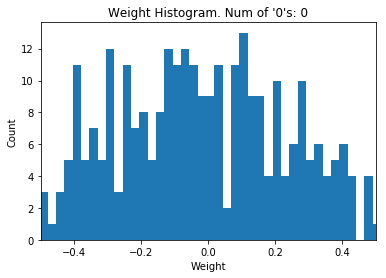

In [11]:
w1 = trained_model.layers[0].get_weights()[0].flatten()
drawWeightHistogram(w1)

In [12]:
def TestModel(model=None, data=None):
    if model is None:
        print("Must provide a trained model.")
        return
    if data is None:
        print("Must provide data.")
        return
    x_test, y_test = data
    scores = model.evaluate(x_test, y_test)
    return scores

In [13]:
test_score = TestModel(model=trained_model, data=[x_test, y_test])
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

2080/2213 [===========================>..] - ETA: 0sTest loss 1.0319, accuracy 52.37%
